# Agregaremos mas datos para reentrenar nuestro modelo:

### 1.Agregamos mas datos de Operacion KUNTOR

In [55]:
#Librerias que se usaran
import pandas as pd  # Libreria para administrar tablas, y realizar trabajos con distintas formas de tablas o dataframes
import numpy as np   # Libreria para poder hacer operaciones matematicas y matriciales
import matplotlib.pyplot as plt # Libreria para realizar graficos 
from tabulate import tabulate   # Permite formatear y mostrar de mejor manera los datos tabulares
import seaborn as sns  # Libreria para realizar graficos y vizualizaciones
import psycopg2        # Libreria que permite la conexion con PostgresSQL
from matplotlib.backends.backend_pdf import PdfPages # Libreria que permite exportar graficos en pdf

Establecemos la conexion con el servidor de Azure, y extraemos datos de Posgresql, que utilizaremos en el analisis

In [3]:
# Información de la conexión a PostgreSQL
host = "kumtorcontrolsensedb.postgres.database.azure.com"
database = "ControlSenseDB"
user = "postgres"
password = "Larc0mar"

# Establecer la conexión a la base de datos
try:
    connection = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )

    # Crear un cursor para ejecutar comandos SQL
    cursor = connection.cursor()

    # Establecer la zona horaria antes de ejecutar la consulta
    time_zone_query = "SET TIME ZONE 'Asia/Bishkek';"
    cursor.execute(time_zone_query)

    # Tu consulta SQL
    tu_query_sql = '''
select * from (select ff.capacidad_en_volumen_equipo_carguio_m3, ff.capacidad_en_peso_equipo_carguio, f.capacidad_pes capacidad_en_peso_equipo_acarreo,
a.tonelajevimsretain tonelaje_camion_antes_cargaestabilizada, t.angulo_giro_promedio angulo_giro_promedio_pases, o.densidad densidad_inicial_poligono_creado,
t.coord_x coord_x_pases, a.tiem_llegada, a.tonelajevims tonelaje_segun_computadora,
ROW_NUMBER() OVER (PARTITION BY a.id ORDER BY a.id DESC) AS RowNum

from public.tp_cargadescarga a
left join (
SELECT tp.id id_ciclo_carguio, tp.id_palas, tp.id_equipo as id_equipo_carguio, 
tp.id_locacion, 
tp.id_poligono, tp.id_trabajador, tp.id_crew, tp.isspot, tp.bool_estado, tp.bool_equipo_next, tp.cola, 
tcd1.tiem_carga as tiempo_inicio_carga_carguio,
tcd1.tiem_acarreo as tiempo_esperando_carguio,
getreadytime( tp.id_equipo, tcd1.tiem_carga, tcd1.tiem_acarreo) tiempo_ready_cargando,
getreadytime( tp.id_equipo, 
			 lag(tcd1.tiem_acarreo) OVER (PARTITION BY (COALESCE(null, true)), tp.id_equipo ORDER BY tcd1.tiem_carga), 
			 tcd1.tiem_carga) tiempo_ready_esperando,
lag(tcd1.tiem_acarreo) OVER (PARTITION BY (COALESCE(null, true)), tp.id_equipo ORDER BY tcd1.tiem_carga) AS previous_esperando_pala,
tcd1.tiem_acarreo,
tcd1.tiem_carga
FROM tp_cargadescarga tcd1
LEFT JOIN tp_palas tp ON tp.id = (SELECT id 
						  FROM tp_palas 
						 	WHERE id_palas = tcd1.id_palas
						 	ORDER BY ID DESC LIMIT 1)
WHERE tcd1.tiem_elimin IS NULL
AND tcd1.tiem_viajando IS NOT NULL
and tp.tiem_elimin IS NULL and tcd1.tiem_carga > CAST('2023-01-01' AS DATE)) m
on a.id_palas = m.id_palas
				 
left join public.ts_poligono o
on m.id_poligono = o.id
				 
left join (select d.id_principal, c.id id_equipo,
c.capacidad_pes, c.capacidadtanque
from public.ts_equipos c
inner join (select b.id id_principal , b.nombre principal, a.id id_secundario , a.nombre secundario from public.ts_equipos a
inner join (select id, nombre from public.ts_equipos where id_flota = 0 and tiem_elimin is null) b
on b.id = a.id_flota
where a.tiem_elimin is null) d
on d.id_secundario = c.id_flota
where c.id_flota <> 0 and c.isflota = false and c.tiem_elimin is null
order by d.id_principal) f
on a.id_equipo = f.id_equipo

left join (select d.id_principal, c.capacidad_vol capacidad_en_volumen_equipo_carguio_m3, c.id id_equipo,
c.capacidad_pes capacidad_en_peso_equipo_carguio, c.radiohexagonocuchara radiohexagonocuchara_equipocarguio
from public.ts_equipos c
inner join (select b.id id_principal , b.nombre principal, a.id id_secundario , a.nombre secundario from public.ts_equipos a
inner join (select id, nombre from public.ts_equipos where id_flota = 0 and tiem_elimin is null) b
on b.id = a.id_flota
where a.tiem_elimin is null) d
on d.id_secundario = c.id_flota
where c.id_flota <> 0 and c.isflota = false and c.tiem_elimin is null
order by d.id_principal) ff
on m.id_equipo_carguio = ff.id_equipo

left join (select z.* from
    (select A.id, A.id_equipo,
    A.tiempo_estimado tiempo_estimado_duracion_estado, 
    ROW_NUMBER() OVER (PARTITION BY A.id_equipo ORDER BY A.id_equipo) AS row_num
    from public.tp_estados A
    left join public.ts_detal_estado B on A.id_detal_estado = B.id_detal_estado
    --left join (select * from public.ts_detal_estado where id=B.id_tipo_estad limit 1) C on true
    where A.tiem_elimin is null) z
    WHERE
    z.row_num = 1) ss
on m.id_equipo_carguio = ss.id_equipo

left join public.ts_locacion n
on m.id_locacion = n.id
left join (select * from public.ta_datacarga_sensores 
where tiem_elimin is NULL) t
on a.id_cargadescarga = t.id_cargadescarga
where a.tiem_elimin is null and a.tiem_llegada > CAST('2023-01-01' AS DATE)) z
where z.RowNum = 1
    '''

    # Ejecutar la consulta
    cursor.execute(tu_query_sql)

    # Obtener los resultados en un DataFrame de pandas
    resultados_datos = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

    # Cerrar el cursor y la conexión
    cursor.close()
    connection.close()

    # Hacer lo que necesites con los resultados
    print(resultados_datos.head())

except psycopg2.Error as e:
    print("Error al conectar a la base de datos PostgreSQL:", e)

   capacidad_en_volumen_equipo_carguio_m3  capacidad_en_peso_equipo_carguio  capacidad_en_peso_equipo_acarreo  tonelaje_camion_antes_cargaestabilizada  angulo_giro_promedio_pases  densidad_inicial_poligono_creado                     coord_x_pases               tiem_llegada  tonelaje_segun_computadora  rownum
0                               23.000000                         40.000000                        130.000000                                      NaN                         NaN                          2.850000                              None 2023-08-30 06:21:02.266402                         NaN       1
1                               23.000000                         40.000000                        172.000000                                      NaN                         NaN                          2.850000                              None 2023-08-30 06:18:40.292708                         NaN       1
2                                     NaN                             

In [89]:
#Configuramos pandas para que podamos vizualizar todas las columnas y filas la estadistica descriptiva de todas las variables
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
#Configuramos pandas para que lanze valores con una precision de hasta 6 decimales
pd.set_option('display.float_format', '{:.6f}'.format)
# Restaurar la configuración predeterminada
#pd.set_option('display.float_format', None) 

# Guardamos los datos extraidos de Azure

In [4]:
#Se guardaron los datos que fueron traidos de AZURE POSTGRESS
resultados_datos.to_csv('masdatos_modelo_opkuntor_vf.csv', index=False)

Leemos los datos Capturados (+ DATOS )

In [145]:
datos_kuntor = pd.read_csv('masdatos_modelo_opkuntor_vf.csv')
datos_kuntor.head()

,capacidad_en_volumen_equipo_carguio_m3,capacidad_en_peso_equipo_carguio,capacidad_en_peso_equipo_acarreo,tonelaje_camion_antes_cargaestabilizada,angulo_giro_promedio_pases,densidad_inicial_poligono_creado,coord_x_pases,tiem_llegada,tonelaje_segun_computadora,rownum
0,23.000000,40.000000,130.000000,NaN,NaN,2.850000,NaN,2023-08-30 06:21:02.266402,NaN,1
1,23.000000,40.000000,172.000000,NaN,NaN,2.850000,NaN,2023-08-30 06:18:40.292708,NaN,1
2,NaN,NaN,172.000000,1963.000000,60.000000,NaN,"[851757, 851809, 851615, 851572]",2023-08-30 06:18:28.340000,1840.000000,1
3,NaN,NaN,172.000000,NaN,NaN,NaN,NaN,2023-08-30 06:17:30.262000,NaN,1
4,NaN,NaN,172.000000,1744.000000,54.000000,NaN,"[759243, 759440, 759608]",2023-08-30 06:16:52.062000,1764.000000,1


### 2. Preprocesamiento de datos

Tratamiento de Valores Faltantes

In [146]:
print(datos_kuntor.isnull().sum())

capacidad_en_volumen_equipo_carguio_m3       3703
capacidad_en_peso_equipo_carguio             3703
capacidad_en_peso_equipo_acarreo                4
tonelaje_camion_antes_cargaestabilizada     28107
angulo_giro_promedio_pases                 413078
densidad_inicial_poligono_creado               60
coord_x_pases                              413078
tiem_llegada                                    0
tonelaje_segun_computadora                   9342
rownum                                          0
dtype: int64


In [147]:
#Funcion para tratamiento de Valores Nulos (completar los Nulos por las Medias)
import pandas as pd

def llenar_nulos_con_media(df, nombre_columna):
    media_columna = df[nombre_columna].mean()
    df[nombre_columna] = df[nombre_columna].fillna(media_columna)
    return df

In [148]:
# Columnas específicas en las que deseas eliminar las filas con nulos
columnas_a_verificar = ['angulo_giro_promedio_pases', 'coord_x_pases']

# Elimina las filas que contienen valores nulos en las columnas especificadas
datos_kuntor = datos_kuntor.dropna(subset=columnas_a_verificar)

# Supongamos que deseas completar los valores nulos en la columna 'nombre_columna' con el valor 0
datos_kuntor = llenar_nulos_con_media(datos_kuntor, 'capacidad_en_volumen_equipo_carguio_m3')
datos_kuntor = llenar_nulos_con_media(datos_kuntor, 'capacidad_en_peso_equipo_carguio')
datos_kuntor = llenar_nulos_con_media(datos_kuntor, 'capacidad_en_peso_equipo_acarreo')
datos_kuntor = llenar_nulos_con_media(datos_kuntor, 'tonelaje_camion_antes_cargaestabilizada')
datos_kuntor = llenar_nulos_con_media(datos_kuntor, 'densidad_inicial_poligono_creado')
datos_kuntor = llenar_nulos_con_media(datos_kuntor, 'tonelaje_segun_computadora')


# Rellenar los valores nulos con ceros en todo el DataFrame
#datos = datos.fillna(0)

# Muestra la cantidad de valores nulos después de eliminar filas
print("\nValores nulos después de eliminar filas:")
print(datos_kuntor.isnull().sum())


Valores nulos después de eliminar filas:
capacidad_en_volumen_equipo_carguio_m3     0
capacidad_en_peso_equipo_carguio           0
capacidad_en_peso_equipo_acarreo           0
tonelaje_camion_antes_cargaestabilizada    0
angulo_giro_promedio_pases                 0
densidad_inicial_poligono_creado           0
coord_x_pases                              0
tiem_llegada                               0
tonelaje_segun_computadora                 0
rownum                                     0
dtype: int64


Calculo de Nuevas variables y prepocesamiento de datos

In [149]:
# Agregamos la variable calculada "numero_pases_carguio" basado en la columna 'coord_x_pases'
datos_kuntor['numero_pases_carguio'] = datos_kuntor['coord_x_pases'].apply(lambda x: len(eval(x)) if isinstance(x, str) and '[' in x else x if isinstance(x, int) else 0)

# Supongamos que 'datos' es tu DataFrame y 'columnas_a_eliminar' es una lista con los nombres de las columnas a eliminar
columnas_a_eliminar = ['coord_x_pases', 'rownum']

datos_kuntor = datos_kuntor.drop(columns=columnas_a_eliminar)

# Transformamos la dimension de esta variable
datos_kuntor['tonelaje_camion_antes_cargaestabilizada'] = datos_kuntor['tonelaje_camion_antes_cargaestabilizada'] / 10

datos_kuntor['tonelaje_segun_computadora'] = datos_kuntor['tonelaje_segun_computadora'] / 10

#cambiamos el nombre de la variable
datos_kuntor.rename(columns={'densidad_inicial_poligono_creado': 'densidad_inicial_poligono_creado_tn/m3'}, inplace=True)

datos_kuntor.rename(columns={'tiem_llegada': 'tiempo_llegada_camion'}, inplace=True)

Transformacion de Variables de fecha a formato DateTime

In [135]:
# Convierte la columna 'tiempo_llegada_camion' a tipo datetime si aún no lo es
datos_kuntor['tiempo_llegada_camion'] = pd.to_datetime(datos_kuntor['tiempo_llegada_camion'], errors='coerce')

In [137]:
# Cambiar '0000' a '9999' en los milisegundos
datos_kuntor['tiempo_llegada_camion'] = datos_kuntor['tiempo_llegada_camion'].dt.strftime('%Y-%m-%d %H:%M:%S.%f').str[:-4] + '9999'

In [139]:
datos_kuntor['tiempo_llegada_camion'] = pd.to_datetime(datos_kuntor['tiempo_llegada_camion'], errors='coerce')

In [150]:
datos_kuntor.dtypes

capacidad_en_volumen_equipo_carguio_m3     float64
capacidad_en_peso_equipo_carguio           float64
capacidad_en_peso_equipo_acarreo           float64
tonelaje_camion_antes_cargaestabilizada    float64
angulo_giro_promedio_pases                 float64
densidad_inicial_poligono_creado_tn/m3     float64
tiempo_llegada_camion                       object
tonelaje_segun_computadora                 float64
numero_pases_carguio                         int64
dtype: object

In [141]:
#Agregemos la Zona Horaria a la fecha
datos_kuntor['tiempo_llegada_camion'] = datos_kuntor['tiempo_llegada_camion'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bishkek')

In [151]:
# lista de columnas 'columnas_fecha' que contienen fechas
columnas_fecha = ['tiempo_llegada_camion']  

#1. Itera sobre las columnas de fechas y convierte cada una datetime
for columna in columnas_fecha:
    datos_kuntor[columna] = pd.to_datetime(datos_kuntor[columna], errors='coerce')  #Coerce reemplaza con Null, si la fecha no tiene el formato de la mayoria

#2. Reemplazas milisengundos 00000   
for columna in columnas_fecha:
    # Cambiar '0000' a '9999' en los milisegundos
    datos_kuntor[columna] = datos_kuntor[columna].dt.strftime('%Y-%m-%d %H:%M:%S.%f').str[:-4] + '9999'

#3. Una vez reemplzar los 0000 milisegundos, debemos volverlos a convertir a datetime
for columna in columnas_fecha:
    datos_kuntor[columna] = pd.to_datetime(datos_kuntor[columna], errors='coerce')

#4. Agregamos la Zona Horaria 
for columna in columnas_fecha:
    #Agregemos la Zona Horaria a la fecha
    datos_kuntor[columna] = datos_kuntor[columna].dt.tz_localize('UTC').dt.tz_convert('Asia/Bishkek')


#  Iterar sobre las columnas y reemplazar NaT con la fecha de la fila anterior + 3 segundos
# for columna in columnas_fecha:
#     mask_nat = datos_kuntor[columna].isna()
#     datos_kuntor[columna].loc[mask_nat] = datos_kuntor[columna].fillna(method='ffill') + pd.to_timedelta(3, unit='s')

Verificamos si en KUNTOR si la variable "NUMERO DE PASES" tienen valores outliers

In [154]:
datos_kuntor['numero_pases_carguio'].unique()

array([ 4,  3,  6,  5,  1,  8,  7,  2,  9, 13, 11, 10, 12, 14, 16, 15, 18,
       22, 17, 19, 21, 23], dtype=int64)

### 3. Leemos los datos utilizados en el modelo original(OP.MARCOBRE)

In [155]:
#Cargar los datos en formato Datetime (variables de tiempo)
datos_marcobre = pd.read_csv('datos_opmarcobre.csv', parse_dates=['tiempo_llegada_camion'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f%z'))
datos_marcobre.head()

C:\Users\BryanInche-MS4M\AppData\Local\Temp\ipykernel_2868\2440694692.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  datos_marcobre = pd.read_csv('datos_opmarcobre.csv', parse_dates=['tiempo_llegada_camion'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f%z'))


,capacidad_en_volumen_equipo_carguio_m3,capacidad_en_peso_equipo_carguio,capacidad_en_peso_equipo_acarreo,tonelaje_camion_antes_cargaestabilizada,angulo_giro_promedio_pases,densidad_inicial_poligono_creado_tn/m3,tiempo_llegada_camion,tonelaje_segun_computadora,numero_pases_carguio
0,23.000000,39.158333,229.000000,225.800000,0.000000,1.916910,2022-01-01 07:01:58.086000-05:00,235.800000,4
1,23.000000,39.158333,229.000000,243.500000,20.000000,2.200000,2022-01-01 07:04:06.421000-05:00,234.500000,7
2,23.000000,39.158333,229.000000,232.900000,0.000000,1.916910,2022-01-01 07:06:43.839000-05:00,235.400000,4
3,23.000000,39.158333,229.000000,234.900000,43.000000,2.200000,2022-01-01 07:12:42.484000-05:00,234.900000,7
4,23.000000,39.158333,229.000000,238.400000,0.000000,1.916910,2022-01-01 07:15:32.741000-05:00,247.700000,4


In [156]:
datos_marcobre.dtypes

capacidad_en_volumen_equipo_carguio_m3                       float64
capacidad_en_peso_equipo_carguio                             float64
capacidad_en_peso_equipo_acarreo                             float64
tonelaje_camion_antes_cargaestabilizada                      float64
angulo_giro_promedio_pases                                   float64
densidad_inicial_poligono_creado_tn/m3                       float64
tiempo_llegada_camion                      datetime64[ns, UTC-05:00]
tonelaje_segun_computadora                                   float64
numero_pases_carguio                                           int64
dtype: object

Verificamos si en MARCOBRE si la variable "NUMERO DE PASES" tienen valores outliers 

In [157]:
datos_marcobre['numero_pases_carguio'].unique()

array([4, 7, 5, 6, 8], dtype=int64)

### 4. Tratamiento de Valores Outliers (Asignamos los limites de Marcobre a Kuntor, para tener una generalizacion de los datos)

In [158]:
# Calcular Q1 y Q3 de la columna en el primer DataFrame
Q1_primer_df = datos_marcobre['numero_pases_carguio'].quantile(0.25)
Q3_primer_df = datos_marcobre['numero_pases_carguio'].quantile(0.75)

# Calcular el rango intercuartilico (IQR) en el primer DataFrame
IQR_primer_df = Q3_primer_df - Q1_primer_df

# Calcular los límites inferior y superior del bigote en el primer DataFrame
limite_inferior_primer_df = round(Q1_primer_df - 1.5 * IQR_primer_df)
limite_superior_primer_df = round(Q3_primer_df + 1.5 * IQR_primer_df)

# Limitar los valores atípicos en el segundo DataFrame a los límites del primer DataFrame
datos_kuntor['numero_pases_carguio'] = datos_kuntor['numero_pases_carguio'].clip(lower=limite_inferior_primer_df, upper=limite_superior_primer_df)

In [159]:
datos_kuntor['numero_pases_carguio'].unique()

array([4, 6, 5, 8, 7], dtype=int64)

In [160]:
datos_kuntor.head(1)

,capacidad_en_volumen_equipo_carguio_m3,capacidad_en_peso_equipo_carguio,capacidad_en_peso_equipo_acarreo,tonelaje_camion_antes_cargaestabilizada,angulo_giro_promedio_pases,densidad_inicial_poligono_creado_tn/m3,tiempo_llegada_camion,tonelaje_segun_computadora,numero_pases_carguio
2,18.001554,32.102646,172.000000,196.300000,60.000000,2.777849,2023-08-30 12:18:28.349999+06:00,184.000000,4


In [161]:
#Se guardan los datos que han sido preprocesados y calidad en los datos y cambiados nombres
datos_kuntor.to_csv('datos_opkuntor.csv', date_format='%Y-%m-%d %H:%M:%S.%f%z', index=False)

### Cargamos los datos de KUNTOR

In [162]:
#Cargar los datos en formato Datetime (variables de tiempo)
datos_kuntor = pd.read_csv('datos_opkuntor.csv', parse_dates=['tiempo_llegada_camion'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f%z'))
datos_kuntor.head()

C:\Users\BryanInche-MS4M\AppData\Local\Temp\ipykernel_2868\3642732282.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  datos_kuntor = pd.read_csv('datos_opkuntor.csv', parse_dates=['tiempo_llegada_camion'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f%z'))


,capacidad_en_volumen_equipo_carguio_m3,capacidad_en_peso_equipo_carguio,capacidad_en_peso_equipo_acarreo,tonelaje_camion_antes_cargaestabilizada,angulo_giro_promedio_pases,densidad_inicial_poligono_creado_tn/m3,tiempo_llegada_camion,tonelaje_segun_computadora,numero_pases_carguio
0,18.001554,32.102646,172.000000,196.300000,60.000000,2.777849,2023-08-30 12:18:28.349999+06:00,184.000000,4
1,18.001554,32.102646,172.000000,174.400000,54.000000,2.777849,2023-08-30 12:16:52.069999+06:00,176.400000,4
2,18.001554,32.102646,178.000000,179.400000,81.000000,2.777849,2023-08-30 12:16:41.379999+06:00,178.400000,4
3,18.001554,32.102646,130.000000,135.900000,48.000000,2.777849,2023-08-30 12:14:34.509999+06:00,125.500000,4
4,18.001554,32.102646,172.000000,168.000000,20.000000,2.777849,2023-08-30 12:14:01.699999+06:00,172.500000,6


Verificamos si Ambas operaciones (Marcobre y Kuntor) no tienen Outliers

In [163]:
print(f'marcobre',datos_marcobre['numero_pases_carguio'].unique() ,  'kuntor' ,datos_kuntor['numero_pases_carguio'].unique())

marcobre [4 7 5 6 8] kuntor [4 6 5 8 7]


In [164]:
datos_kuntor.head(1)

,capacidad_en_volumen_equipo_carguio_m3,capacidad_en_peso_equipo_carguio,capacidad_en_peso_equipo_acarreo,tonelaje_camion_antes_cargaestabilizada,angulo_giro_promedio_pases,densidad_inicial_poligono_creado_tn/m3,tiempo_llegada_camion,tonelaje_segun_computadora,numero_pases_carguio
0,18.001554,32.102646,172.000000,196.300000,60.000000,2.777849,2023-08-30 12:18:28.349999+06:00,184.000000,4


In [165]:
datos_marcobre.head(1)

,capacidad_en_volumen_equipo_carguio_m3,capacidad_en_peso_equipo_carguio,capacidad_en_peso_equipo_acarreo,tonelaje_camion_antes_cargaestabilizada,angulo_giro_promedio_pases,densidad_inicial_poligono_creado_tn/m3,tiempo_llegada_camion,tonelaje_segun_computadora,numero_pases_carguio
0,23.000000,39.158333,229.000000,225.800000,0.000000,1.916910,2022-01-01 07:01:58.086000-05:00,235.800000,4


In [166]:
datos_marcobre.shape, datos_kuntor.shape

((743993, 9), (380660, 9))

### 5. Guardamos los datos de MARCOBRE + KUNTOR

In [167]:
# Concatenar los nuevos datos con los datos originales
datos_combinados = pd.concat([datos_marcobre, datos_kuntor], axis=0)  # axis=0, unir por filas

# Guardamos el df en un archivo csv
datos_combinados.to_csv('datos_marcobre_mas_kuntor.csv', date_format='%Y-%m-%d %H:%M:%S.%f%z', index=False)

### 6. Cargamos los datos consolidados (Marcobre + Kuntor) (Con el formato adecuado de DateTime)

In [168]:
datos = pd.read_csv('datos_marcobre_mas_kuntor.csv', parse_dates=['tiempo_llegada_camion'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f%z'))
datos.head()

C:\Users\BryanInche-MS4M\AppData\Local\Temp\ipykernel_2868\3977618124.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  datos = pd.read_csv('datos_marcobre_mas_kuntor.csv', parse_dates=['tiempo_llegada_camion'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S.%f%z'))


,capacidad_en_volumen_equipo_carguio_m3,capacidad_en_peso_equipo_carguio,capacidad_en_peso_equipo_acarreo,tonelaje_camion_antes_cargaestabilizada,angulo_giro_promedio_pases,densidad_inicial_poligono_creado_tn/m3,tiempo_llegada_camion,tonelaje_segun_computadora,numero_pases_carguio
0,23.000000,39.158333,229.000000,225.800000,0.000000,1.916910,2022-01-01 07:01:58.086000-05:00,235.800000,4
1,23.000000,39.158333,229.000000,243.500000,20.000000,2.200000,2022-01-01 07:04:06.421000-05:00,234.500000,7
2,23.000000,39.158333,229.000000,232.900000,0.000000,1.916910,2022-01-01 07:06:43.839000-05:00,235.400000,4
3,23.000000,39.158333,229.000000,234.900000,43.000000,2.200000,2022-01-01 07:12:42.484000-05:00,234.900000,7
4,23.000000,39.158333,229.000000,238.400000,0.000000,1.916910,2022-01-01 07:15:32.741000-05:00,247.700000,4


In [169]:
datos.shape

(1124653, 9)

Identificacion de Valores Duplicados

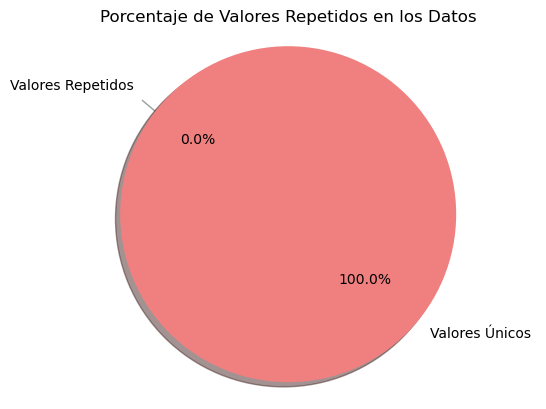

In [173]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame llamado 'datos'
# Utiliza la función `duplicated` para marcar filas duplicadas
duplicados = datos[datos.duplicated(keep=False)]

# Luego, utiliza `groupby` para contar cuántas veces se repite cada fila duplicada
conteo_duplicados = duplicados.groupby(list(datos.columns)).size().reset_index(name='Cantidad')

# Filtra las filas que se repiten al menos 2 veces
conteo_duplicados = conteo_duplicados[conteo_duplicados['Cantidad'] >= 2]

# Calcular el porcentaje de valores repetidos
cantidad_filas_duplicadas = len(conteo_duplicados)
total_filas = len(datos)
porcentaje_repetidos = (cantidad_filas_duplicadas / total_filas) * 100

# Crear un gráfico de pastel
labels = ['Valores Únicos', 'Valores Repetidos']
sizes = [100 - porcentaje_repetidos, porcentaje_repetidos]
colors = ['lightcoral', 'lightblue']
explode = (0, 0.1)  # Destacar la porción de valores repetidos

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Asegurar que el gráfico sea un círculo

plt.title('Porcentaje de Valores Repetidos en los Datos')

plt.show()

Tratamiento de Valores Duplicados

In [171]:
datos = datos.drop_duplicates()

#### Reentrenar el Modelo XGB

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import joblib

# Supongamos que tienes un DataFrame llamado df con tus datos, y la columna objetivo es 'target'
# Asegúrate de tener las características adecuadas para entrenar el modelo

# ... (resto del código para la preparación de datos)

# Cargar el modelo existente
modelo_xgb = joblib.load('xgb.pkl')

# Supongamos que X_nuevos son los nuevos features y y_nuevos son las nuevas etiquetas
dmatrix_nuevos = xgb.DMatrix(X_nuevos, label=y_nuevos)

# Reentrenar el modelo existente con los nuevos datos
modelo_xgb_nuevo = xgb.train(parametros, dmatrix_nuevos, num_boost_round=num_round)

# Guardar el modelo actualizado
joblib.dump(modelo_xgb_nuevo, 'xgb_actualizado.pkl')

Variables general, con las Productividades, para que podamos medir el impacto del modelo

In [ ]:
# Supongamos que datos es tu DataFrame y has seleccionado tus características (X) y variable objetivo (y)
X_gen = datos[['tonelaje_inicial_poligono_creado',
'radiohexagonocuchara_equipocarguio',
'capacidad_en_volumen_equipo_carguio_m3',
'capacidad_en_peso_equipo_carguio',
'capacidad_en_peso_equipo_acarreo',
'tiempo_estimado_duracion_estado_pala',
'radio_locacion_metros',
'tiempo_ready_llegada_esperando',
'tiempo_ready_esperando_cuadra',
'tonelaje_camion_antes_cargaestabilizada',
'angulo_giro_promedio_pases', 
'tonelaje_segun_computadora',
'id_equipo_camion',
'id_equipo_carguio',
'densidad_inicial_poligono_creado_tn/m3', 
'productividad_operativa_acarreo_tn_h',
'tiempo_llegada_camion',
'tiempo_ready_cuadra_cuadrado',
'tiempo_ready_cuadrado_cargado',
'tiempo_ready_carga_acarreo',
'tiempo_ready_acarreo_cola',
'tiempo_ready_cola_retro',
'tiempo_ready_retro_listo',
'tiempo_ready_listo_descarga',
'tiempo_ready_descarga_viajandovacio',
'tiempo_ready_cargando_pala',
'tiempo_ready_esperando_pala',
'productividad_operativa_carguio_tn_h']]  # Reemplaza 'feature1', 'feature2', 'feature3' con tus nombres de características
y_gen = datos['numero_pases_carguio'] # Reemplaza 'variable_objetivo' con el nombre de tu variable objetivo

In [ ]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train_gen, X_test_gen, y_train_gen, y_test_gen = train_test_split(X_gen, y_gen, test_size=0.2, random_state=42)

In [ ]:
# Guardamos el df en un archivo csv
# df_concatenado.to_csv('datos_opmarcobre.csv', index=False)

### 3. Modelos de ML y DL sin Valores atipicos

Hacemos la division entre las variables que seran independientes, y la variable target(dependiente) para los Modelos

In [ ]:
# Supongamos que datos es tu DataFrame y has seleccionado tus características (X) y variable objetivo (y)
X = datos[[#'tonelaje_inicial_poligono_creado',
#'radiohexagonocuchara_equipocarguio',
'capacidad_en_volumen_equipo_carguio_m3',
#'capacidad_en_peso_equipo_carguio',
#'capacidad_en_peso_equipo_acarreo',
#'tiempo_estimado_duracion_estado_pala',
#'radio_locacion_metros',
#'tiempo_ready_llegada_esperando',
#'tiempo_ready_esperando_cuadra',
'tonelaje_camion_antes_cargaestabilizada',
'angulo_giro_promedio_pases',
#'tonelaje_segun_computadora',
#'id_equipo_camion', 'id_equipo_carguio',
'densidad_inicial_poligono_creado_tn/m3']]  # Reemplaza 'feature1', 'feature2', 'feature3' con tus nombres de características
y = datos['numero_pases_carguio'] # Reemplaza 'variable_objetivo' con el nombre de tu variable objetivo

3.1 Regresion Lineal

In [ ]:
# Normalizar los datos, para que la red tenga un mejor rendimiento al procesar datos mas pequenos y en una misma escala
#scaler = StandardScaler()
#X_normalized = scaler.fit_transform(X)

# Convertir DataFrame a array de NumPy
#X_array = X_normalized
#y_array = y.values

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_rl, X_test_rl, y_train_rl, y_test_rl = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión lineal múltiple
modelo_rl = LinearRegression()

# Entrenar el modelo
modelo_rl.fit(X_train_rl, y_train_rl)

# Realizar predicciones en el conjunto de prueba
y_pred_rl = modelo_rl.predict(X_test_rl)

# Redondear los valores de y_pred al entero más cercano
y_pred_rl = np.round(y_pred_rl).astype('int64')

# Medir el rendimiento del modelo
error_absoluto_medio_rl = metrics.mean_absolute_error(y_test_rl, y_pred_rl)
error_cuadratico_medio_rl = metrics.mean_squared_error(y_test_rl, y_pred_rl)
raiz_error_cuadratico_medio_rl = metrics.mean_squared_error(y_test_rl, y_pred_rl, squared=False)
coeficiente_de_determinacion_rl = metrics.r2_score(y_test_rl, y_pred_rl)

# Imprimir métricas de rendimiento
print(f'Error Absoluto Medio: {error_absoluto_medio_rl}')
print(f'Error Cuadrático Medio: {error_cuadratico_medio_rl}')
print(f'Raíz del Error Cuadrático Medio: {raiz_error_cuadratico_medio_rl}')
print(f'Coeficiente de Determinación (R^2): {coeficiente_de_determinacion_rl}')

Error Absoluto Medio: 0.9002009422106332
Error Cuadrático Medio: 1.3753519848923716
Raíz del Error Cuadrático Medio: 1.1727540172143396
Coeficiente de Determinación (R^2): 0.08904218678991593


Un RMSE de 1.52 significa que, en promedio, las predicciones tienen un error de alrededor de 1.52 unidades  de nuemro de pases.

Crear un gráfico de valores reales vs predichos

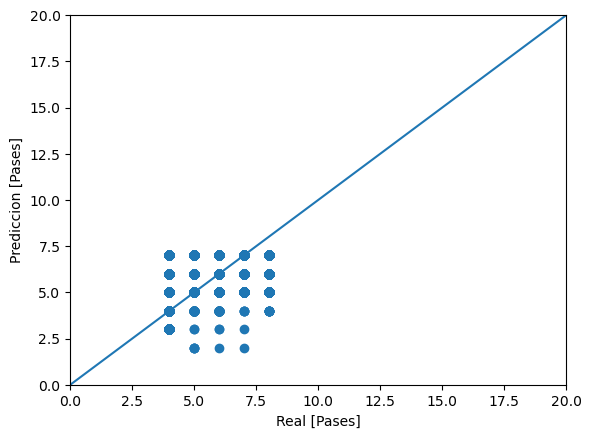

In [ ]:
# Visualizar las predicciones
plt.scatter(y_test_rl, y_pred_rl)
plt.xlabel('Real [Pases]')
plt.ylabel('Prediccion [Pases]')
lims = [0, 20]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

3.2 Arbol de decision Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Supongamos que X es tu conjunto de características y y es tu variable objetivo (Número de Pases)
# Asegúrate de tener definidas estas variables antes de ejecutar el código

# Normalizar los datos, para que la red tenga un mejor rendimiento al procesar datos mas pequenos y en una misma escala
#scaler = StandardScaler()
#X_normalized = scaler.fit_transform(X)

# Convertir DataFrame a array de NumPy
#X_array = X_normalized
#y_array = y.values

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de árbol de decisión para regresión
model_arbol = DecisionTreeRegressor(max_depth=5,random_state=42)

# Entrenar el modelo
model_arbol.fit(X_train_dt, y_train_dt)

# Realizar predicciones en el conjunto de prueba
y_pred_dt = model_arbol.predict(X_test_dt)

# Redondear los valores de y_pred al entero más cercano
y_pred_dt = np.round(y_pred_dt).astype('int64')

# Visualizar el árbol de decisión (opcional)
# Nota: Necesitarás tener instalada la biblioteca graphviz y pydotplus para esto
# from sklearn.tree import export_graphviz
# import pydotplus
# dot_data = export_graphviz(modelo_arbol, out_file=None, feature_names=X.columns, filled=True, rounded=True)
# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_png('arbol_decision.png')

# Medir el rendimiento del modelo
error_absoluto_medio_dt = metrics.mean_absolute_error(y_test_dt, y_pred_dt)
error_cuadratico_medio_dt = metrics.mean_squared_error(y_test_dt, y_pred_dt)
raiz_error_cuadratico_medio_dt = metrics.mean_squared_error(y_test_dt, y_pred_dt, squared=False)

# Imprimir métricas de rendimiento
print(f'Error Absoluto Medio: {error_absoluto_medio_dt}')
print(f'Error Cuadrático Medio: {error_cuadratico_medio_dt}')
print(f'Raíz del Error Cuadrático Medio: {raiz_error_cuadratico_medio_dt}')

Error Absoluto Medio: 0.7508450997654554
Error Cuadrático Medio: 1.1065195330613782
Raíz del Error Cuadrático Medio: 1.0519123219457875


3.3 Random Forest 

Construye cada árbol de forma independiente y paralela. Cada árbol no tiene conocimiento de la existencia de otros árboles.

In [ ]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame llamado df con tus datos, y la columna objetivo es 'target'
# Asegúrate de tener las características adecuadas para entrenar el modelo

# Normalizar los datos, para que la red tenga un mejor rendimiento al procesar datos mas pequenos y en una misma escala
#scaler = StandardScaler()
#X_normalized = scaler.fit_transform(X)

# Convertir DataFrame a array de NumPy
#X_array = X_normalized
#y_array = y.values

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de Random Forest
model_rf = RandomForestRegressor(n_estimators=20, max_depth=5 ,random_state=42)

# Entrenar el modelo
model_rf.fit(X_train_rf, y_train_rf)

# Realizar predicciones en el conjunto de prueba
y_pred_rf = model_rf.predict(X_test_rf)

# Redondear los valores de y_pred al entero más cercano
y_pred_rf = np.round(y_pred_rf).astype('int64')

# Medir el rendimiento del modelo
error_absoluto_medio_rf = metrics.mean_absolute_error(y_test_rf, y_pred_rf)
error_cuadratico_medio_rf = metrics.mean_squared_error(y_test_rf, y_pred_rf)
raiz_error_cuadratico_medio_rf = metrics.mean_squared_error(y_test_rf, y_pred_rf, squared=False)

# Imprimir métricas de rendimiento
print(f'Error Absoluto Medio: {error_absoluto_medio_rf}')
print(f'Error Cuadrático Medio: {error_cuadratico_medio_rf}')
print(f'Raíz del Error Cuadrático Medio: {raiz_error_cuadratico_medio_rf}')

Error Absoluto Medio: 0.7491985833238126
Error Cuadrático Medio: 1.097507375721611
Raíz del Error Cuadrático Medio: 1.047619862221794


3.4 SVM (Support Vector Machine)

In [ ]:
from sklearn.svm import SVR

# Normalizar los datos, para que la red tenga un mejor rendimiento al procesar datos mas pequenos y en una misma escala
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Convertir DataFrame a array de NumPy
X_array = X_normalized
y_array = y.values

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de SVM Regressor
model_svm = SVR(kernel='linear')  # Puedes ajustar los hiperparámetros según sea necesario
model_svm.fit(X_train_svm, y_train_svm)

# Realizar predicciones en el conjunto de prueba con SVM Regressor
y_pred_svm = model_svm.predict(X_test_svm)
y_pred_svm = np.round(y_pred_svm).astype('int64')

# Medir el rendimiento del modelo de SVM Regressor
error_absoluto_medio_svm = metrics.mean_absolute_error(y_test_svm, y_pred_svm)
error_cuadratico_medio_svm = metrics.mean_squared_error(y_test_svm, y_pred_svm)
raiz_error_cuadratico_medio_svm = metrics.mean_squared_error(y_test_svm, y_pred_svm, squared=False)

# Imprimir métricas de rendimiento de SVM Regressor
print("\nMétricas de rendimiento para SVM Regressor:")
print(f'Error Absoluto Medio: {error_absoluto_medio_svm}')
print(f'Error Cuadrático Medio: {error_cuadratico_medio_svm}')
print(f'Raíz del Error Cuadrático Medio: {raiz_error_cuadratico_medio_svm}')

3.5 XGBoost

Construye árboles de manera secuencial. Cada árbol se entrena para corregir los errores de los árboles anteriores.

In [ ]:
# Instalar las bibliotecas necesarias
# pip install xgboost scikit-learn matplotlib

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Supongamos que tienes un DataFrame llamado df con tus datos, y la columna objetivo es 'target'
# Asegúrate de tener las características adecuadas para entrenar el modelo

# Normalizar los datos, para que la red tenga un mejor rendimiento al procesar datos mas pequenos y en una misma escala
#scaler = StandardScaler()
#X_normalized = scaler.fit_transform(X)

# Convertir DataFrame a array de NumPy
#X_array = X_normalized
#y_array = y.values

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de XGBoost
model_xgb = xgb.XGBRegressor(
    learning_rate = 0.1,
    n_estimators=100,  # Número de árboles
    max_depth=7,  # Profundidad máxima de los árboles
    random_state=42
)

# Entrenar el modelo
model_xgb.fit(X_train_xgb, y_train_xgb)

# Realizar predicciones en el conjunto de prueba
y_pred_xgb = model_xgb.predict(X_test_xgb)

# Redondear los valores de y_pred al entero más cercano
y_pred_xgb = np.round(y_pred_xgb).astype('int64')

# Medir el rendimiento del modelo
error_absoluto_medio_xgb = metrics.mean_absolute_error(y_test_xgb, y_pred_xgb)
error_cuadratico_medio_xgb = metrics.mean_squared_error(y_test_xgb, y_pred_xgb)
raiz_error_cuadratico_medio_xgb = metrics.mean_squared_error(y_test_xgb, y_pred_xgb, squared=False)

# Imprimir métricas de rendimiento
print(f'Error Absoluto Medio: {error_absoluto_medio_xgb}')
print(f'Error Cuadrático Medio: {error_cuadratico_medio_xgb}')
print(f'Raíz del Error Cuadrático Medio: {raiz_error_cuadratico_medio_xgb}')

Error Absoluto Medio: 0.7213825361729581
Error Cuadrático Medio: 1.0284948151533277
Raíz del Error Cuadrático Medio: 1.0141473340463543


#### Gridseachr para XGB(Hallar los mejores hiperparametros)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=42)

# Define el modelo XGBoost para regresión
model_xgb_regressor = XGBRegressor()

# Define los hiperparámetros que deseas probar
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [20, 50, 100],
    'max_depth': [3, 5, 7]
}

# Configura la búsqueda de hiperparámetros utilizando GridSearchCV
model_grid_search_xgb = GridSearchCV(estimator=model_xgb_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Ajusta el modelo a los datos de entrenamiento
model_grid_search_xgb.fit(X_train_xgb, y_train_xgb)

# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", model_grid_search_xgb.best_params_)

# Realiza predicciones en el conjunto de prueba
y_pred_xgb = model_grid_search_xgb.predict(X_test_xgb)

# Redondear los valores de y_pred al entero más cercano
y_pred_xgb = np.round(y_pred_xgb).astype('int64')

# Evalúa el rendimiento del modelo en el conjunto de prueba
raiz_error_cuadratico_medio_xgb = metrics.mean_squared_error(y_test_xgb, y_pred_xgb, squared=False)
print(f'Raíz del Error Cuadrático Medio: {raiz_error_cuadratico_medio_xgb}')


Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Raíz del Error Cuadrático Medio: 1.0141473340463543


Guardar el Mejor Modelo en un extension .pkl

In [ ]:
import joblib

# Guardar el modelo en un archivo
joblib.dump(model_xgb, 'modelo_xgb_4var.pkl')

['modelo_xgb_4var.pkl']

Obtener las mejores variables segun el modelo

In [ ]:
# Obtener las importancias de las características
feature_importances = model_xgb.feature_importances_

# Crear un DataFrame para mostrar las importancias de las características junto con sus nombres
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar el DataFrame por importancia en orden descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes
print(feature_importance_df.head(15))

                                   Feature  Importance
0   capacidad_en_volumen_equipo_carguio_m3    0.638024
2               angulo_giro_promedio_pases    0.312969
3   densidad_inicial_poligono_creado_tn/m3    0.036727
1  tonelaje_camion_antes_cargaestabilizada    0.012280


3.6 Red Neuronal

In [ ]:
# Aseguramos que los resultados sean "reproducibles" en cada ejecucion de tensorflow(pesos iniciales aleatorios)
import tensorflow as tf
import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

3.6.2 Red Neuronal LSTM (Recurrente)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import numpy as np

# Normalizar los datos, para que la red tenga un mejor rendimiento al procesar datos mas pequenos y en una misma escala
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Convertir DataFrame a array de NumPy
X_array = X_normalized
y_array = y.values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

#---------------------------------------------------------------------------------------------------------------------------------------
model_rnn = Sequential()
# La forma de entrada para LSTM debe ser (n_timesteps, n_features)
model_rnn.add(LSTM(30, activation='relu', input_shape=(1, 4)))  #  (n_samples, n_pasos, n_variables)
# Agregar capas Dense según sea necesario
model_rnn.add(Dense(60, activation='relu'))
model_rnn.add(Dense(30, activation='relu'))
model_rnn.add(Dense(15, activation='relu'))
# Capa de salida
model_rnn.add(Dense(1, activation='linear'))
#-------------------------------------------------------------------------------------------------------------------------------------------

# Compilar el modelo
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
# Imprimir un resumen del modelo
model_rnn.summary()

# Entrenar el modelo
#X_train_rnn.reshape(-1, 1, 1) significa que quieres que NumPy calcule automáticamente el tamaño de la dimensión correspondiente a n_samples
#Si tienes 15 variables en cada paso de tiempo, entonces la forma de entrada para la capa LSTM debería ser (n_samples, n_timesteps, n_features). 
#En este caso, la dimensión n_features debería ser 15
model_rnn.fit(X_train_rnn.reshape(-1, 1, 4), y_train_rnn, epochs=15, batch_size=5, verbose=1) # (n_samples, n_pasos, n_variables)

# Hacer predicciones en el conjunto de prueba
y_pred_rnn = model_rnn.predict(X_test_rnn.reshape(-1, 1, 4)) # (n_samples, n_pasos, n_variables)

# Redondear los valores de y_pred al entero más cercano
y_pred_rnn = np.round(y_pred_rnn).astype('int64')

# Calcular el error cuadrático medio en el conjunto de prueba
mse = mean_squared_error(y_test_rnn, y_pred_rnn)
# Calcular la raíz cuadrada del error cuadrático medio
rmse = np.sqrt(mse)

print(f'Raíz del Error Cuadrático Medio en el conjunto de prueba: {rmse}')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30)                4200      
                                                                 
 dense_8 (Dense)             (None, 60)                1860      
                                                                 
 dense_9 (Dense)             (None, 30)                1830      
                                                                 
 dense_10 (Dense)            (None, 15)                465       
                                                                 
 dense_11 (Dense)            (None, 1)                 16        
                                                                 
Total params: 8371 (32.70 KB)
Trainable params: 8371 (32.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
119039/11

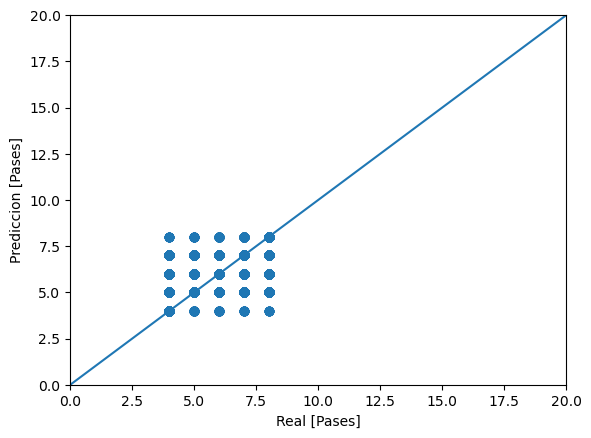

In [ ]:
# Visualizar las predicciones
plt.scatter(y_test_rnn, y_pred_rnn)
plt.xlabel('Real [Pases]')
plt.ylabel('Prediccion [Pases]')
lims = [0, 20]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)